In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sim_data import SHTMSampler

In [3]:
from simple_hierarchical_topic_model import (
    SimpleHierarchicalTopicModel,
    StoppingCondition,
    StatsSaver,
    explore_branching_factors,
)

In [4]:
from initializers import KMeansInitializer, UniformInitializer, CustomInitializer

In [5]:
from param_stats import mean_discrete, mean_dirichlet, variance_discrete, norm_variance_dirichlet, topic_difference

In [6]:
from collections import OrderedDict

In [7]:
import os
import sys
sys.path.append(os.path.abspath(".."))
import text_utils

In [8]:
import pandas as pd

In [9]:
def run_analysis(data, sim, train_rand_seed, train_params, trial_group_id, saver = None):
    np.random.seed(train_rand_seed)
    model = SimpleHierarchicalTopicModel(**train_params)
    model.fit(data)
    if saver is not None:
        saver(
            trial_group_id = trial_group_id,
            train_rand_seed = train_rand_seed,
            train_params = train_params,
            sim = sim,
            model = model)

In [10]:
rows = []
def saver(**kwargs):
    global rows
    model = kwargs["model"]
    sim = kwargs["sim"]
    del kwargs["model"]
    del kwargs["sim"]

    row = dict()
    row.update(kwargs)

    topic_vectors = model.get_expected_topic_vectors()
    init_topics = mean_dirichlet(model.stats_by_epoch[0]["var_params_DV"])

    row["final_topic_difference"] = topic_difference(true_topics=sim.topics_by_index, est_topics=topic_vectors, paths = model.nodes)
    row["final_ELBO"] = model.stats_by_epoch[-1]["ELBO"]

    print("{}: final_topic_difference: {}".format(row["trial_group_id"], row["final_topic_difference"]), file=sys.stderr)
    
    rows.append(row)

In [11]:
%%time
np.random.seed(1)
sim = SHTMSampler(
    branching_factors = [2],
    num_docs = 1000,
    doc_length = 200,
    topic_sharpness = 20,
    alpha_leaves = 0.01,
    alpha_depths = 1,
    heavy_words_per_topic = 2,
    #overlap = 'full',
    #heavy_indices = [[0, 1], [2, 3], [2, 4], [3, 4]],
    #vocab_size = 5,
)
docs = sim.generate()
data, vocab = text_utils.document_strings_to_sparse_term_doc(
    docs = docs,
    tokenizer = text_utils.default_tokenizer,
    vocab = sim.vocab)

CPU times: user 9.45 s, sys: 50.1 ms, total: 9.5 s
Wall time: 9.55 s


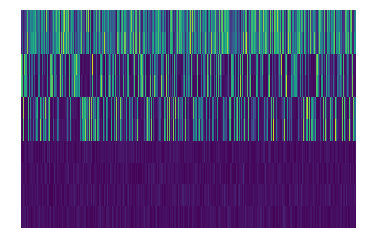

In [12]:
fig, ax = plt.subplots()
ax.imshow(data.todense(), aspect='auto')
ax.axis('off')
None

In [13]:
paths = explore_branching_factors(sim.branching_factors)

In [14]:
base_train_params = dict(
    branching_factors = sim.branching_factors,
    stopping_condition = StoppingCondition(min_rel_increase = 1e-5, delay_epochs = 5, max_epochs = 300),
    #stopping_condition = StoppingCondition(max_epochs = 200),
    #stopping_condition = StoppingCondition(max_epochs = 5),
    batch_size = None,
    vocab = sim.vocab,
    save_params_history = True,
    step_size_function = lambda n: 0.5,
    #paths = [(i,) for i in range(sim.num_leaves)],
    prior_params_DL = sim.alpha_leaves,
    prior_params_DD = sim.alpha_depths,
    prior_params_DV = 0.1,
    #update_order = ["D", "L", "DD", "DL", "DV", ],
    stats_saver = StatsSaver("latest_stats.txt", stats = ["epoch_index", "ELBO", "var_params_DV"]),
    #initializer = KMeansInitializer(data = data, paths = paths, low = 0.01, high = 1.99),
    #initializer = UniformInitializer(low = 0.01, high = 1.99),
    initializer = CustomInitializer(sim, topics_noise = 0.0),  # <-- "cheating" based on simulation
)

In [15]:
num_trials = 20
noise_levels = [0.0, 0.1, 0.5, 1.0]
for topics_noise in noise_levels:
    train_params = dict()
    train_params.update(base_train_params)
    train_params["initializer"] = CustomInitializer(sim, topics_noise = topics_noise)
    for seed in range(1, num_trials + 1):
        run_analysis(
            trial_group_id = "topics_noise_{}".format(topics_noise),
            data = data,
            sim = sim,
            train_rand_seed = seed,
            train_params = train_params,
            saver = saver)

 58%|█████▊    | 174/300 [02:21<01:39,  1.27it/s, Status=computing statistics]
topics_noise_0.0: final_topic_difference: 0.054594906336845384
 58%|█████▊    | 174/300 [02:22<01:39,  1.26it/s, Status=computing statistics]
topics_noise_0.0: final_topic_difference: 0.05459490633684342
 58%|█████▊    | 174/300 [02:23<01:45,  1.20it/s, Status=computing statistics]
topics_noise_0.0: final_topic_difference: 0.05459490633684369
 58%|█████▊    | 174/300 [02:36<01:45,  1.20it/s, Status=computing statistics]
topics_noise_0.0: final_topic_difference: 0.05459490633684246
 58%|█████▊    | 174/300 [02:31<01:42,  1.23it/s, Status=computing statistics]
topics_noise_0.0: final_topic_difference: 0.054594906336844384
 58%|█████▊    | 174/300 [02:25<02:05,  1.01it/s, Status=computing statistics]
topics_noise_0.0: final_topic_difference: 0.054594906336844405
 58%|█████▊    | 174/300 [02:26<01:43,  1.21it/s, Status=computing statistics]
topics_noise_0.0: final_topic_difference: 0.05459490633684171
 58%|█████

 65%|██████▌   | 195/300 [02:38<01:24,  1.25it/s, Status=computing statistics]
topics_noise_0.5: final_topic_difference: 0.050702721569379966
 38%|███▊      | 113/300 [01:34<02:26,  1.27it/s, Status=computing statistics]
topics_noise_0.5: final_topic_difference: 0.04293387737879101
 57%|█████▋    | 170/300 [02:20<01:42,  1.27it/s, Status=computing statistics]
topics_noise_1.0: final_topic_difference: 0.04864562042675915
 52%|█████▏    | 156/300 [02:07<01:52,  1.28it/s, Status=computing statistics]
topics_noise_1.0: final_topic_difference: 0.04719726067472497
 34%|███▍      | 102/300 [01:24<02:34,  1.28it/s, Status=computing statistics]
topics_noise_1.0: final_topic_difference: 0.0426786756402216
 48%|████▊     | 144/300 [01:57<02:07,  1.23it/s, Status=computing statistics]
topics_noise_1.0: final_topic_difference: 0.046449216181644076
 35%|███▌      | 106/300 [01:27<02:31,  1.28it/s, Status=computing statistics]
topics_noise_1.0: final_topic_difference: 0.0416847973715481
 47%|████▋   

In [16]:
df = pd.DataFrame.from_records(rows)
df = df.loc[:, sorted(df.columns)]

In [17]:
g = df.groupby(["trial_group_id"])

In [18]:
stats = ["final_topic_difference", "final_ELBO"]
rows = []
for group_name in sorted(g.groups.keys()):
    subset = g.get_group(group_name)
    row = OrderedDict([("group_name", group_name)])
    for s in stats:
        mean = subset[s].mean()
        std = subset[s].std()
        row[s + "_mean"] = mean
        row[s + "_std"] = std
    rows.append(row)
df_summary = pd.DataFrame.from_records(rows)
df_summary

,group_name,final_topic_difference_mean,final_topic_difference_std,final_ELBO_mean,final_ELBO_std
0,topics_noise_0.0,0.054595,1.101053e-15,-342996.746294,1.699655e-10
1,topics_noise_0.1,0.049156,1.522747e-03,-343009.241904,2.606659e+01
2,topics_noise_0.5,0.045692,2.362931e-03,-342968.928171,8.786992e+01
3,topics_noise_1.0,0.098112,1.681047e-01,-342989.701077,4.712822e+02


In [19]:
from io import StringIO

In [20]:
sio = StringIO()
df_summary.to_csv(sio)
print(sio.getvalue())

,group_name,final_topic_difference_mean,final_topic_difference_std,final_ELBO_mean,final_ELBO_std
0,topics_noise_0.0,0.054594906336843205,1.1010527459609333e-15,-342996.7462944819,1.6996553053344402e-10
1,topics_noise_0.1,0.04915625677288507,0.001522747285718868,-343009.2419040369,26.066591192841898
2,topics_noise_0.5,0.0456919627121498,0.00236293066325738,-342968.9281711435,87.86992270896489
3,topics_noise_1.0,0.09811214167598269,0.16810468267094564,-342989.7010773847,471.2822333175385



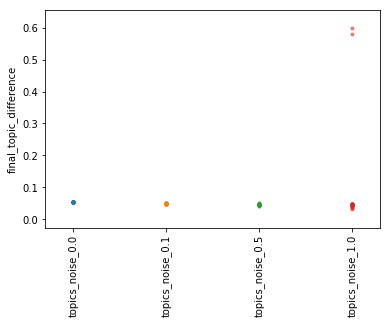

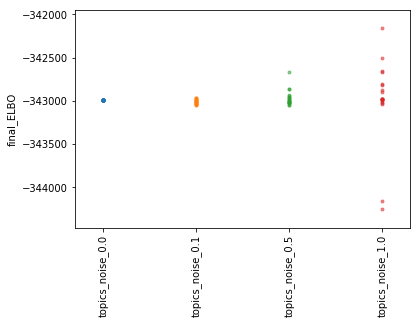

In [28]:
for stat in stats:
    fig, ax = plt.subplots()
    xticks = np.arange(df_summary.shape[0])
    xlabels = df_summary["group_name"]
    for i, group_name in enumerate(xlabels):
        current_group = g.get_group(group_name)
        ax.plot([i for _ in range(current_group.shape[0])], current_group[stat], linestyle='', marker='.', alpha=0.5)
    ax.set_ylabel(stat)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels, rotation=90)
    ax.margins(0.1, 0.1)